# Guide To Sequence Tagging With Neural Networks In Python

This is the third post in my series about named entity recognition. If you haven’t seen the last two, have a look now. The last time we used a conditional random field to model the sequence structure of our sentences. This time we use a LSTM model to do the tagging. At the end of this guide, you will know how to use neural networks in keras to tag sequences of words. For more details on neural networks and LSTMs in particular, I suggest to read this excellent blog post.

Now we want to apply this model. Let’s start by loading the data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [6]:
n_words = len(words); n_words

35179

In [7]:
tags = list(set(data["Tag"].values))

In [8]:
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [9]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)

In [11]:
sent = getter.get_next()

This is how a sentence looks now.

In [12]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Okay, that looks like expected, now get all sentences.

In [13]:
sentences = getter.sentences

Now check how long the senctences are.

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

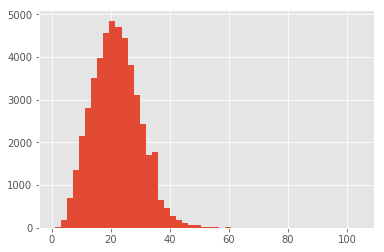

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

For the use of neural nets (at least with keras, this is no theoretical reason) we need to use equal-lenght input sequences. So we are going to pad our sentences to a length of 50. But first we need dictionaries of words and tags.

In [16]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
word2idx["Obama"]

10123

In [23]:
tag2idx["B-geo"]

2

Now we map the senctences to a sequence of numbers and then pad the sequence.

In [25]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [28]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [29]:
X[1]

array([16571, 20593, 22333, 32554, 32868,  8601, 12500, 33531,  8601,
       10288, 10646, 17705, 31874, 25576, 12307, 25900, 30254,  4875,
        6449,  8900, 10729, 20761, 25020, 14624, 23352, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

And we need to do the same for our tag sequence.

In [30]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [32]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [33]:
y[1]

array([0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 3, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9], dtype=int32)

For training the network we also need to change the labels y to categorial.

In [36]:
from keras.utils import to_categorical

In [37]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

We split in train and test set.

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

Now we can fit a LSTM network with an embedding layer. Note that we used the functional API of keras here, as it is more suitable for complicated architectures.

In [42]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [43]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
model = Model(input, out)

In [45]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 93s 2ms/step - loss: 0.1392 - acc: 0.9646 - val_loss: 0.0645 - val_acc: 0.9816
Epoch 2/5
38846/38846 [==============================] - 102s 3ms/step - loss: 0.0549 - acc: 0.9840 - val_loss: 0.0532 - val_acc: 0.9847
Epoch 3/5
38846/38846 [==============================] - 100s 3ms/step - loss: 0.0457 - acc: 0.9867 - val_loss: 0.0497 - val_acc: 0.9855
Epoch 4/5
38846/38846 [==============================] - 100s 3ms/step - loss: 0.0412 - acc: 0.9880 - val_loss: 0.0479 - val_acc: 0.9859
Epoch 5/5
38846/38846 [==============================] - 102s 3ms/step - loss: 0.0382 - acc: 0.9887 - val_loss: 0.0473 - val_acc: 0.9857


In [47]:
hist = pd.DataFrame(history.history)

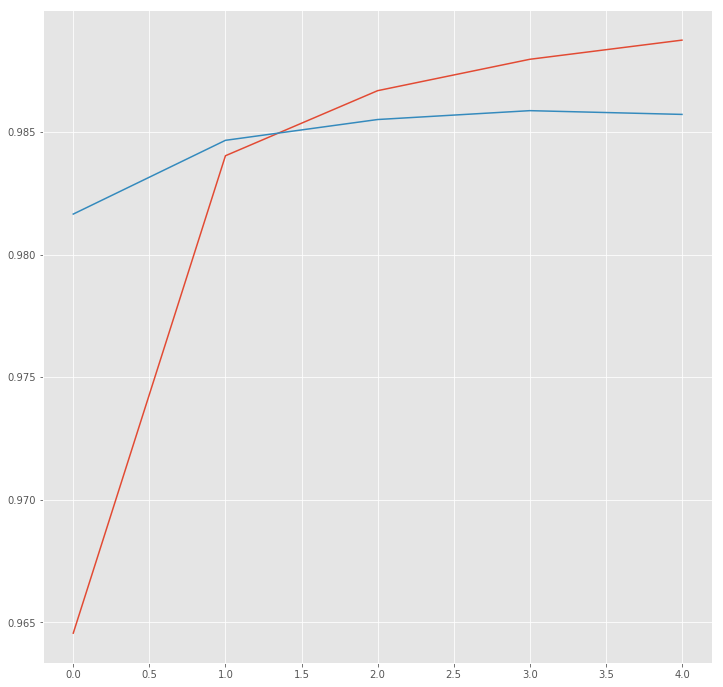

In [48]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

Now look at some predictions.

In [49]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
The            : O
United         : B-org
Nations        : I-org
says           : O
foreign        : O
companies      : O
,              : O
many           : O
from           : O
Europe         : B-geo
,              : O
began          : O
dumping        : O
toxic          : O
waste          : O
on             : O
Somalia        : B-geo
's             : O
shore          : O
in             : O
the            : O
1980s          : B-tim
,              : O
but            : O
the            : O
practice       : O
accelerated    : O
after          : O
the            : O
1991           : B-tim
overthrow      : O
of             : O
dictator       : O
Mohamed        : B-per
Siad           : I-per
Barre          : I-per
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
END

This looks pretty good and it did require any feature engineering. So feel free to try some of the proposed methods yourself and have a look at an interesting application here. In the next post I’ll show you a combination of a CRF and a LSTM for sequence tagging.